# Import packages and data

In [53]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [54]:
# Import training data
X_train = pd.read_csv("ais_train.csv", sep="|")
data = X_train.copy()

# Importing test data
X_test = pd.read_csv("ais_test.csv")

# Import ports data
ports = pd.read_csv("ports.csv", sep="|")

# Import vessels data
vessels = pd.read_csv("vessels.csv", sep="|")

#Import schedules data
schedules = pd.read_csv("schedules_to_may_2024.csv", sep="|")

# Data Inspection

## AIS training

In [55]:
data.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3


In [56]:
data.sample(5)

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
543012,2024-02-17 04:13:11,38.0,0.0,0,298,5,02-17 04:45,35.45300,139.68818,61e9f472b937134a3c4c02d9,61d379f61366c3998241d8d2
1492896,2024-05-05 14:37:28,294.4,0.0,0,60,5,05-04 04:00,45.55149,13.73627,61e9f3dbb937134a3c4bff3d,61d37ee629b60f6113c89d04
728650,2024-03-04 19:18:42,31.0,0.0,0,31,5,03-04 23:30,41.36382,2.17511,61e9f469b937134a3c4c029f,61d37f9c29b60f6113c89e65
62655,2024-01-06 09:39:38,258.1,1.1,0,208,0,01-09 17:30,-40.24122,173.80741,61e9f477b937134a3c4c02e9,61d37bff99db2ccf7339ece5
270251,2024-01-24 18:33:25,342.4,10.6,0,340,0,12-06 20:00,34.51539,137.07116,61e9f424b937134a3c4c00cd,61d37a361366c3998241d950


In [57]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
cog,1522065.0,178.249396,107.678507,0.00000,78.20000,183.80000,269.00000,360.00000
sog,1522065.0,6.331703,7.539364,0.00000,0.00000,0.50000,14.10000,102.30000
rot,1522065.0,0.505456,17.609157,-127.00000,0.00000,0.00000,0.00000,128.00000
heading,1522065.0,176.273681,107.085986,0.00000,75.00000,180.00000,265.00000,511.00000
navstat,1522065.0,2.092604,2.411965,0.00000,0.00000,0.00000,5.00000,15.00000
latitude,1522065.0,36.584970,22.904879,-47.53287,34.51683,42.23370,51.35197,70.55720
longitude,1522065.0,11.536464,68.715718,-167.54093,-5.21281,4.23435,18.83715,178.80538


In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522065 entries, 0 to 1522064
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   time       1522065 non-null  object 
 1   cog        1522065 non-null  float64
 2   sog        1522065 non-null  float64
 3   rot        1522065 non-null  int64  
 4   heading    1522065 non-null  int64  
 5   navstat    1522065 non-null  int64  
 6   etaRaw     1522065 non-null  object 
 7   latitude   1522065 non-null  float64
 8   longitude  1522065 non-null  float64
 9   vesselId   1522065 non-null  object 
 10  portId     1520450 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 127.7+ MB


In [59]:
# Check for null values
data.isnull().sum()

time            0
cog             0
sog             0
rot             0
heading         0
navstat         0
etaRaw          0
latitude        0
longitude       0
vesselId        0
portId       1615
dtype: int64

In [60]:
#Counted duplicate rows
len(data)-len(data.drop_duplicates())

0

In [61]:
# Count the occurence of navstat values
data['navstat'].value_counts()

navstat
0     782099
5     605831
1     129515
2       2081
8        948
15       670
6        521
4        232
3        161
11         2
12         1
13         1
14         1
7          1
9          1
Name: count, dtype: int64

<Axes: xlabel='sog'>

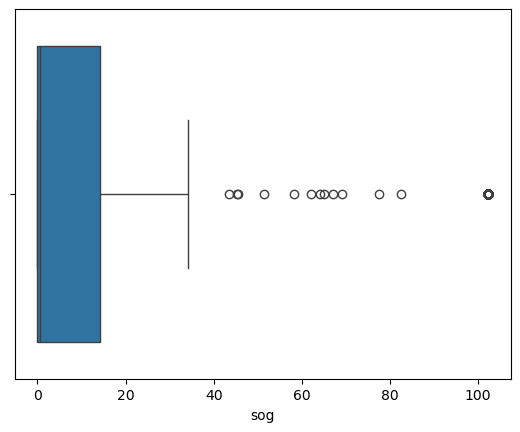

In [62]:
# Plot sog in a boxplot to get an idea of outliers
sns.boxplot(x = 'sog', data = data)

In [105]:
# Count number of rows with sog over 40, which seems to represent the upper outliers
df_sog_greater_40 = data[data['sog'] > 40]    

unique_vessels_sog_greater_40 = df_sog_greater_40['vesselId'].unique()

#print(unique_vessels_sog_greater_40)
print('Number of unique vessels that travel over 40:', len(unique_vessels_sog_greater_40))
print('Number of entries in data with speeds over 40:', (data['sog'] > 40).sum())

Number of unique vessels that travel over 40: 33
Number of entries in data with speeds over 40: 417


<Axes: xlabel='heading'>

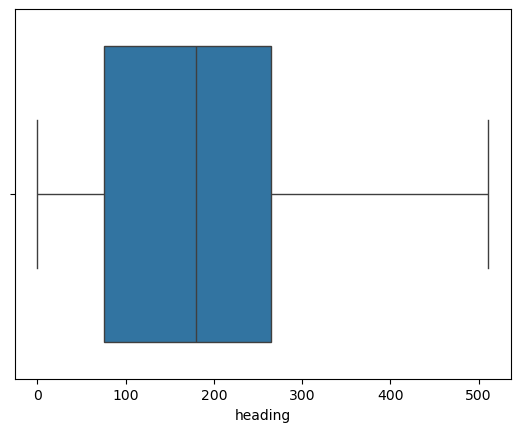

In [64]:
# Plot heading to get an idea of outliers
sns.boxplot(x = 'heading', data = data)

## Ports

In [65]:
ports.head()

,portId,name,portLocation,longitude,latitude,UN_LOCODE,countryName,ISO
0,61d36ed80a1807568ff9a064,Port of Algiers,Algiers,3.067222,36.773611,DZALG,Algeria,DZ
1,61d36ed80a1807568ff9a065,Port of Annaba,Annaba,7.772500,36.900556,DZAAE,Algeria,DZ
2,61d36edf0a1807568ff9a070,Port of Oran,Oran,-0.639722,35.712222,DZORN,Algeria,DZ
3,61d36ee00a1807568ff9a072,Port of Skikda,Skikda,6.905833,36.887500,DZSKI,Algeria,DZ
4,61d36ee10a1807568ff9a074,Port of Pago-Pago,Pago-Pago,-170.690556,-14.274167,ASPPG,American Samoa,AS


In [66]:
ports.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,1329.0,20.630528,67.458101,-173.300000,-4.933,13.933,44.583000,178.426111
latitude,1329.0,35.146181,25.098764,-53.794444,25.920,39.050,53.882778,71.643056


In [67]:
ports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1329 entries, 0 to 1328
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   portId        1329 non-null   object 
 1   name          1329 non-null   object 
 2   portLocation  1329 non-null   object 
 3   longitude     1329 non-null   float64
 4   latitude      1329 non-null   float64
 5   UN_LOCODE     1329 non-null   object 
 6   countryName   1329 non-null   object 
 7   ISO           1329 non-null   object 
dtypes: float64(2), object(6)
memory usage: 83.2+ KB


In [68]:
ports.isnull().sum()

portId          0
name            0
portLocation    0
longitude       0
latitude        0
UN_LOCODE       0
countryName     0
ISO             0
dtype: int64

## Vessels

In [69]:
vessels.head()

,shippingLineId,vesselId,CEU,DWT,GT,NT,vesselType,breadth,depth,draft,enginePower,freshWater,fuel,homePort,length,maxHeight,maxSpeed,maxWidth,rampCapacity,yearBuilt
0,61a8e672f9cba188601e84ab,61e9f38eb937134a3c4bfd8b,6500,21200.0,58684,17606.0,83.0,32.0,22.20,NaN,0.0,NaN,NaN,OSLO,199.00,5.0,18.6,15.2,150.0,2000
1,61ec94f1a8cafc0e93f0e92a,61e9f38eb937134a3c4bfd8d,4902,12325.0,46800,NaN,83.0,31.0,NaN,NaN,14220.0,NaN,NaN,MONROVIA,182.00,NaN,NaN,NaN,NaN,2006
2,61e213d5d612676a0f0fb755,61e9f38eb937134a3c4bfd8f,5000,13059.0,46800,NaN,83.0,31.0,NaN,NaN,14220.0,NaN,NaN,SAINT JOHN'S,182.00,NaN,NaN,NaN,NaN,2010
3,61be24574ea00ae59d0fe388,61e9f38eb937134a3c4bfd91,4200,12588.0,39362,NaN,83.0,28.0,NaN,NaN,11060.0,NaN,NaN,NaN,167.00,NaN,NaN,NaN,NaN,2011
4,61a8e673f9cba188601e84ae,61e9f390b937134a3c4bfd93,7450,21052.0,75528,24391.0,83.0,37.2,22.23,NaN,13140.0,491.47,3236.78,Panama,199.98,NaN,NaN,NaN,NaN,2018


In [70]:
vessels.describe().T

,count,mean,std,min,25%,50%,75%,max
CEU,711.0,5006.454290,2186.256335,0.00,3800.00,5400.000,6500.0000,8500.00
DWT,703.0,18556.291607,8562.952922,3222.00,14267.00,18720.000,21281.0000,108650.00
GT,711.0,51207.534459,16329.899399,8659.00,39362.00,56738.000,60619.5000,100430.00
NT,187.0,17931.326203,3838.264571,3137.00,15576.00,18474.000,19152.0000,29329.00
vesselType,699.0,72.424893,23.366361,14.00,83.00,83.000,83.0000,83.00
breadth,703.0,31.102703,3.563432,18.00,31.00,32.000,32.2600,42.00
depth,242.0,21.383140,2.658188,11.90,21.12,21.310,22.0400,32.60
draft,10.0,9.750000,3.229355,5.75,7.64,9.185,9.9325,15.40
enginePower,691.0,6789.522431,7342.526020,0.00,0.00,0.000,14121.0000,36000.00
freshWater,221.0,484.764932,136.657132,178.85,369.00,471.000,567.0000,806.58


In [71]:
vessels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   shippingLineId  711 non-null    object 
 1   vesselId        711 non-null    object 
 2   CEU             711 non-null    int64  
 3   DWT             703 non-null    float64
 4   GT              711 non-null    int64  
 5   NT              187 non-null    float64
 6   vesselType      699 non-null    float64
 7   breadth         703 non-null    float64
 8   depth           242 non-null    float64
 9   draft           10 non-null     float64
 10  enginePower     691 non-null    float64
 11  freshWater      221 non-null    float64
 12  fuel            221 non-null    float64
 13  homePort        573 non-null    object 
 14  length          711 non-null    float64
 15  maxHeight       35 non-null     float64
 16  maxSpeed        213 non-null    float64
 17  maxWidth        35 non-null     flo

In [72]:
vessels.isnull().sum()

shippingLineId      0
vesselId            0
CEU                 0
DWT                 8
GT                  0
NT                524
vesselType         12
breadth             8
depth             469
draft             701
enginePower        20
freshWater        490
fuel              490
homePort          138
length              0
maxHeight         676
maxSpeed          498
maxWidth          676
rampCapacity      677
yearBuilt           0
dtype: int64

## Schedule

In [73]:
schedules.head()

,vesselId,shippingLineId,shippingLineName,arrivalDate,sailingDate,portName,portId,portLatitude,portLongitude
0,61e9f3b1b937134a3c4bfe53,61a8e672f9cba188601e84ac,Wallenius Wilhelmsen Ocean,2023-10-02 00:00:00+00:00,2023-10-03 00:00:00+00:00,Port of Brunswick,61d38499b7b7526e1adf3d54,31.140556,-81.496667
1,61e9f3b1b937134a3c4bfe53,61a8e672f9cba188601e84ac,Wallenius Wilhelmsen Ocean,2023-10-27 00:00:00+00:00,2023-10-27 00:00:00+00:00,Port of Southampton,61d3832bb7b7526e1adf3b63,50.902500,-1.428889
2,61e9f3b1b937134a3c4bfe53,61a8e672f9cba188601e84ac,Wallenius Wilhelmsen Ocean,2023-10-19 00:00:00+00:00,2023-10-20 00:00:00+00:00,Port of Bremerhaven,61d375e793c6feb83e5eb3e2,53.563611,8.554722
3,61e9f3b1b937134a3c4bfe53,61a8e672f9cba188601e84ac,Wallenius Wilhelmsen Ocean,2023-10-09 00:00:00+00:00,2023-10-10 00:00:00+00:00,Port of New York,61d38481b7b7526e1adf3d23,40.688333,-74.028611
4,61e9f3b1b937134a3c4bfe53,61a8e672f9cba188601e84ac,Wallenius Wilhelmsen Ocean,2023-09-25 00:00:00+00:00,2023-09-26 00:00:00+00:00,Manzanillo International Terminal,61d37d0199db2ccf7339eee1,9.372370,-79.879790


In [74]:
schedules.describe().T

,count,mean,std,min,25%,50%,75%,max
portLatitude,131848.0,28.021038,27.401476,-37.832778,19.208333,35.164167,50.902500,68.795000
portLongitude,131848.0,4.338822,80.059006,-149.571389,-76.558889,3.207222,39.299167,174.771111


In [75]:
schedules.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136250 entries, 0 to 136249
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   vesselId          131635 non-null  object 
 1   shippingLineId    136250 non-null  object 
 2   shippingLineName  136250 non-null  object 
 3   arrivalDate       130735 non-null  object 
 4   sailingDate       134369 non-null  object 
 5   portName          131848 non-null  object 
 6   portId            131848 non-null  object 
 7   portLatitude      131848 non-null  float64
 8   portLongitude     131848 non-null  float64
dtypes: float64(2), object(7)
memory usage: 9.4+ MB


In [76]:
schedules.isnull().sum()

vesselId            4615
shippingLineId         0
shippingLineName       0
arrivalDate         5515
sailingDate         1881
portName            4402
portId              4402
portLatitude        4402
portLongitude       4402
dtype: int64

## Comparative

In [77]:
# Get the unique vessels that are in both training and test data set into a list
unique_vessels_training = data['vesselId'].unique()
unique_vessels_test = X_test['vesselId'].unique()

common_vessels = list(set(unique_vessels_training) & set(unique_vessels_test))

print('Number of vessels that are in training:', len(unique_vessels_training))
print('Number of vessels that are in test:', len(unique_vessels_test))
print('Number of vessels that are the same in training and test:', len(common_vessels))

Number of vessels that are in training: 688
Number of vessels that are in test: 215
Number of vessels that are the same in training and test: 215


In [108]:
common_vessels_sog_40 = list(set(unique_vessels_sog_greater_40) & set(unique_vessels_test))

print('Number of vessels with sog over 40:', len(unique_vessels_sog_greater_40))
print('Number of unique vessels that are in test:', len(unique_vessels_test))
print('Number of vessels that have sog over 40 and are in test:', len(common_vessels_sog_40))

Number of vessels with sog over 40: 33
Number of unique vessels that are in test: 215
Number of vessels that have sog over 40 and are in test: 18


# Data manipulation

## Preprocessing

In [78]:
def preprocess(df):
    data = df.copy()

    # Extract calendar features for 'etaRaw'
    data[['etaMonth', 'etaDay', 'etaHour', 'etaMinute']] = data['etaRaw'].str.extract(r'(\d{2})-(\d{2}) (\d{2}):(\d{2})')

    # Extract calendar features for 'time'
    data[['timeYear', 'timeMonth', 'timeDay', 'timeHour', 'timeMinute', 'timeSecond']] = data['time'].str.extract(r'(\d{2})-(\d{2})-(\d{2}) (\d{2}):(\d{2}):(\d{2})')

    # Convert objects to integers
    data[['etaMonth', 'etaDay', 'etaHour', 'etaMinute', 'timeYear', 'timeMonth', 'timeDay', 'timeHour', 'timeMinute', 'timeSecond']] = data[['etaMonth', 'etaDay', 'etaHour', 'etaMinute', 'timeYear', 'timeMonth', 'timeDay', 'timeHour', 'timeMinute', 'timeSecond']].astype(int)

    # Drop time and etaRaw columns
    data.drop(columns=['time', 'etaRaw'], inplace=True)

    # Removing sog outliers 
    data = data[data['sog'] <= 40]
    
    return data

## Feature Engineering

In [79]:
def feature_engineering(df):  
    data = df.copy()

    # Preprocess the data
    data = preprocess(data)

    # Create lagged columns for longitude and latitude
    data['longitude_lag1'] = data['longitude'].shift(1)
    data['latitude_lag1'] = data['latitude'].shift(1)

    # Insert longitude and latitude lag before longitude and latitude
    data.insert(5, 'longitude_lag1', data.pop('longitude_lag1'))
    data.insert(5, 'latitude_lag1', data.pop('latitude_lag1'))

    # New feature for if the vessel is moored or not
    data['is_moored'] = data['navstat'].apply(lambda x: 1 if x == 5 else 0)
    data.insert(5, 'is_moored', data.pop('is_moored'))


    return data

In [80]:
df_preprocessed = preprocess(data)
df_preprocessed.head()

,cog,sog,rot,heading,navstat,latitude,longitude,vesselId,portId,etaMonth,etaDay,etaHour,etaMinute,timeYear,timeMonth,timeDay,timeHour,timeMinute,timeSecond
0,284.0,0.7,0,88,0,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f,1,9,23,0,24,1,1,0,0,25
1,109.6,0.0,-6,347,1,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689,12,29,20,0,24,1,1,0,0,36
2,111.0,11.0,0,112,0,39.19065,-76.47567,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19,1,2,9,0,24,1,1,0,1,45
3,96.4,0.0,0,142,1,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126,12,31,20,0,24,1,1,0,3,11
4,214.0,19.7,0,215,0,35.88379,-5.91636,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3,1,25,12,0,24,1,1,0,3,51


In [81]:
df_feature_engineered = feature_engineering(data)

df_feature_engineered.head()

,cog,sog,rot,heading,navstat,is_moored,latitude_lag1,longitude_lag1,latitude,longitude,...,etaMonth,etaDay,etaHour,etaMinute,timeYear,timeMonth,timeDay,timeHour,timeMinute,timeSecond
0,284.0,0.7,0,88,0,0,NaN,NaN,-34.74370,-57.85130,...,1,9,23,0,24,1,1,0,0,25
1,109.6,0.0,-6,347,1,0,-34.74370,-57.85130,8.89440,-79.47939,...,12,29,20,0,24,1,1,0,0,36
2,111.0,11.0,0,112,0,0,8.89440,-79.47939,39.19065,-76.47567,...,1,2,9,0,24,1,1,0,1,45
3,96.4,0.0,0,142,1,0,39.19065,-76.47567,-34.41189,151.02067,...,12,31,20,0,24,1,1,0,3,11
4,214.0,19.7,0,215,0,0,-34.41189,151.02067,35.88379,-5.91636,...,1,25,12,0,24,1,1,0,3,51


In [82]:
# Check to see that the is_moored function worked
moored_rows = df_feature_engineered[df_feature_engineered['navstat']==5]
#moored_rows.head()

In [83]:
# Took out the rows for vessel 61e9f3a8b937134a3c4bfdf7
mask = data['vesselId'].values == '61e9f3a8b937134a3c4bfdf7'

df_one_vessel = data.loc[mask]
df_one_vessel = feature_engineering(df_one_vessel)

In [84]:
df_one_vessel.head()

,cog,sog,rot,heading,navstat,is_moored,latitude_lag1,longitude_lag1,latitude,longitude,...,etaMonth,etaDay,etaHour,etaMinute,timeYear,timeMonth,timeDay,timeHour,timeMinute,timeSecond
0,284.0,0.7,0,88,0,0,NaN,NaN,-34.74370,-57.85130,...,1,9,23,0,24,1,1,0,0,25
2672,92.8,14.2,0,90,0,0,-34.74370,-57.85130,-35.16787,-56.77210,...,1,9,23,0,24,1,1,6,9,8
2947,90.5,14.3,0,88,0,0,-35.16787,-56.77210,-35.16863,-56.63185,...,1,9,23,0,24,1,1,6,38,19
3093,88.2,14.3,0,86,0,0,-35.16863,-56.63185,-35.16805,-56.53190,...,1,9,23,0,24,1,1,6,58,55
3140,88.3,12.3,0,86,0,0,-35.16805,-56.53190,-35.16715,-56.45306,...,1,9,23,0,24,1,1,7,15,56


In [85]:
# Find correlation between features and longitude and latitude
df_one_vessel.corr(numeric_only=True).abs()[['longitude', 'latitude']]

,longitude,latitude
cog,0.095041,0.091378
sog,0.394124,0.390246
rot,0.027387,0.008094
heading,0.027000,0.088619
navstat,0.123589,0.201442
is_moored,0.012057,0.084927
latitude_lag1,0.243483,0.995594
longitude_lag1,0.991123,0.248673
latitude,0.247482,1.000000
longitude,1.000000,0.247482
